In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano.tensor as tt
from pymc3.distributions.dist_math import bound

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [3]:
%config InlineBackend.figure_format = 'retina'
az.style.use("arviz-darkgrid")

(array([1000.,    0.,    1.,   37.,  218.,  366.,  269.,   87.,   21.,
           1.]),
 array([  17.97254138,  172.29899146,  326.62544155,  480.95189163,
         635.27834171,  789.6047918 ,  943.93124188, 1098.25769197,
        1252.58414205, 1406.91059214, 1561.23704222]),
 <BarContainer object of 10 artists>)

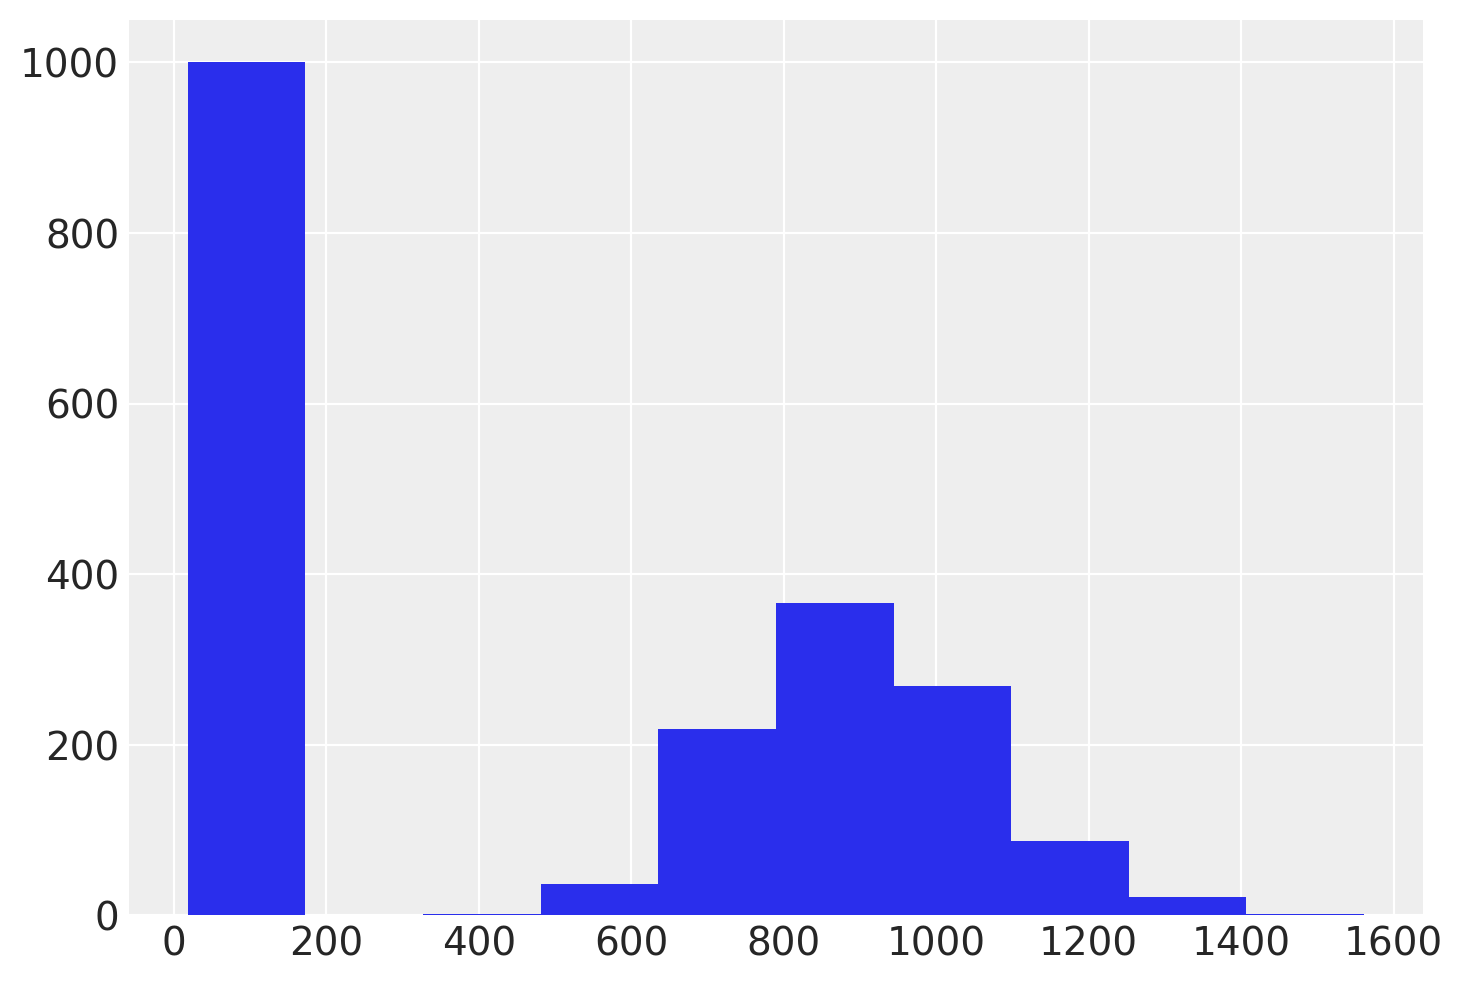

In [18]:
# simulate data from a known mixture distribution
np.random.seed(12345)  # set random seed for reproducibility

k = 2
ndata = 1000
# spread = 5
# centers = np.array([-spread, 0, spread])

# simulate data from mixture distribution

v = np.random.randint(0, k, ndata)
data_1 = np.random.gamma(shape = 20, scale = 2, size = ndata)
data_2 = np.random.gamma(shape = 30, scale = 30, size = ndata)

data = np.append(data_1, data_2)
plt.hist(data)

In [19]:
#definir a GPD
#definir a mistura de gammas
#definir a densidade usando as duas
#https://docs.pymc.io/api/distributions/mixture.html
#https://docs.pymc.io/PyMC3_and_Theano.html

In [20]:
# setup model
model = pm.Model()
with model:
    # cluster sizes
    p = pm.Dirichlet("p", a=np.array([1.0, 1.0]), shape=k)
    
    # ensure all clusters have some points
    p_min_potential = pm.Potential("p_min_potential", tt.switch(tt.min(p) < 0.1, -np.inf, 0))

    # cluster centers
    shape = pm.Gamma("shape", alpha = [0.0001, 0.0001], beta = [0.0001, 0.0001], shape=k)
    # break symmetry
    scale = pm.Gamma("scale", alpha = [0.0001, 0.0001], beta = [0.0001, 0.0001], shape=k)
    
    order_means_potential = pm.Potential(
        "order_means_potential",
        tt.switch(shape[1]*scale[1] - shape[0]*scale[0] < 0, -np.inf, 0))

    
    # likelihood for each observed value
    gamma1 = pm.Gamma.dist(alpha=shape[0], beta = 1/scale[0])
    gamma2 = pm.Gamma.dist(alpha=shape[1], beta = 1/scale[1])
    
    like = pm.Mixture('like', w=p, comp_dists = [gamma1, gamma2], observed=data)

In [21]:
# fit model
with model:
    step1 = pm.Metropolis(vars=[p, shape, scale])
    tr = pm.sample(10000, step=[step1], tune=5000)

/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:4: FutureWarning: In v4.0, pm.sample will return an `arviz.InferenceData` object instead of a `MultiTrace` by default. You can pass return_inferencedata=True or return_inferencedata=False to be safe and silence this warning.
  after removing the cwd from sys.path.
Multiprocess sampling (2 chains in 2 jobs)
CompoundStep
>Metropolis: [scale]
>Metropolis: [shape]
>Metropolis: [p]


/usr/local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
/usr/local/lib/python3.7/site-packages/pymc3/step_methods/metropolis.py:226: RuntimeWarning: overflow encountered in exp
  "accept": np.exp(accept),
Sampling 2 chains for 5_000 tune and 10_000 draw iterations (10_000 + 20_000 draws total) took 24 seconds.
The rhat statistic is larger than 1.05 for some parameters. This indicates slight problems during sampling.
The estimated number of effective samples is smaller than 200 for some parameters.


/usr/local/lib/python3.7/site-packages/ipykernel_launcher.py:1: DeprecationWarning: The function `traceplot` from PyMC3 is just an alias for `plot_trace` from ArviZ. Please switch to `pymc3.plot_trace` or `arviz.plot_trace`.
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


array([[<AxesSubplot:title={'center':'p'}>,
        <AxesSubplot:title={'center':'p'}>],
       [<AxesSubplot:title={'center':'shape'}>,
        <AxesSubplot:title={'center':'shape'}>],
       [<AxesSubplot:title={'center':'scale'}>,
        <AxesSubplot:title={'center':'scale'}>]], dtype=object)

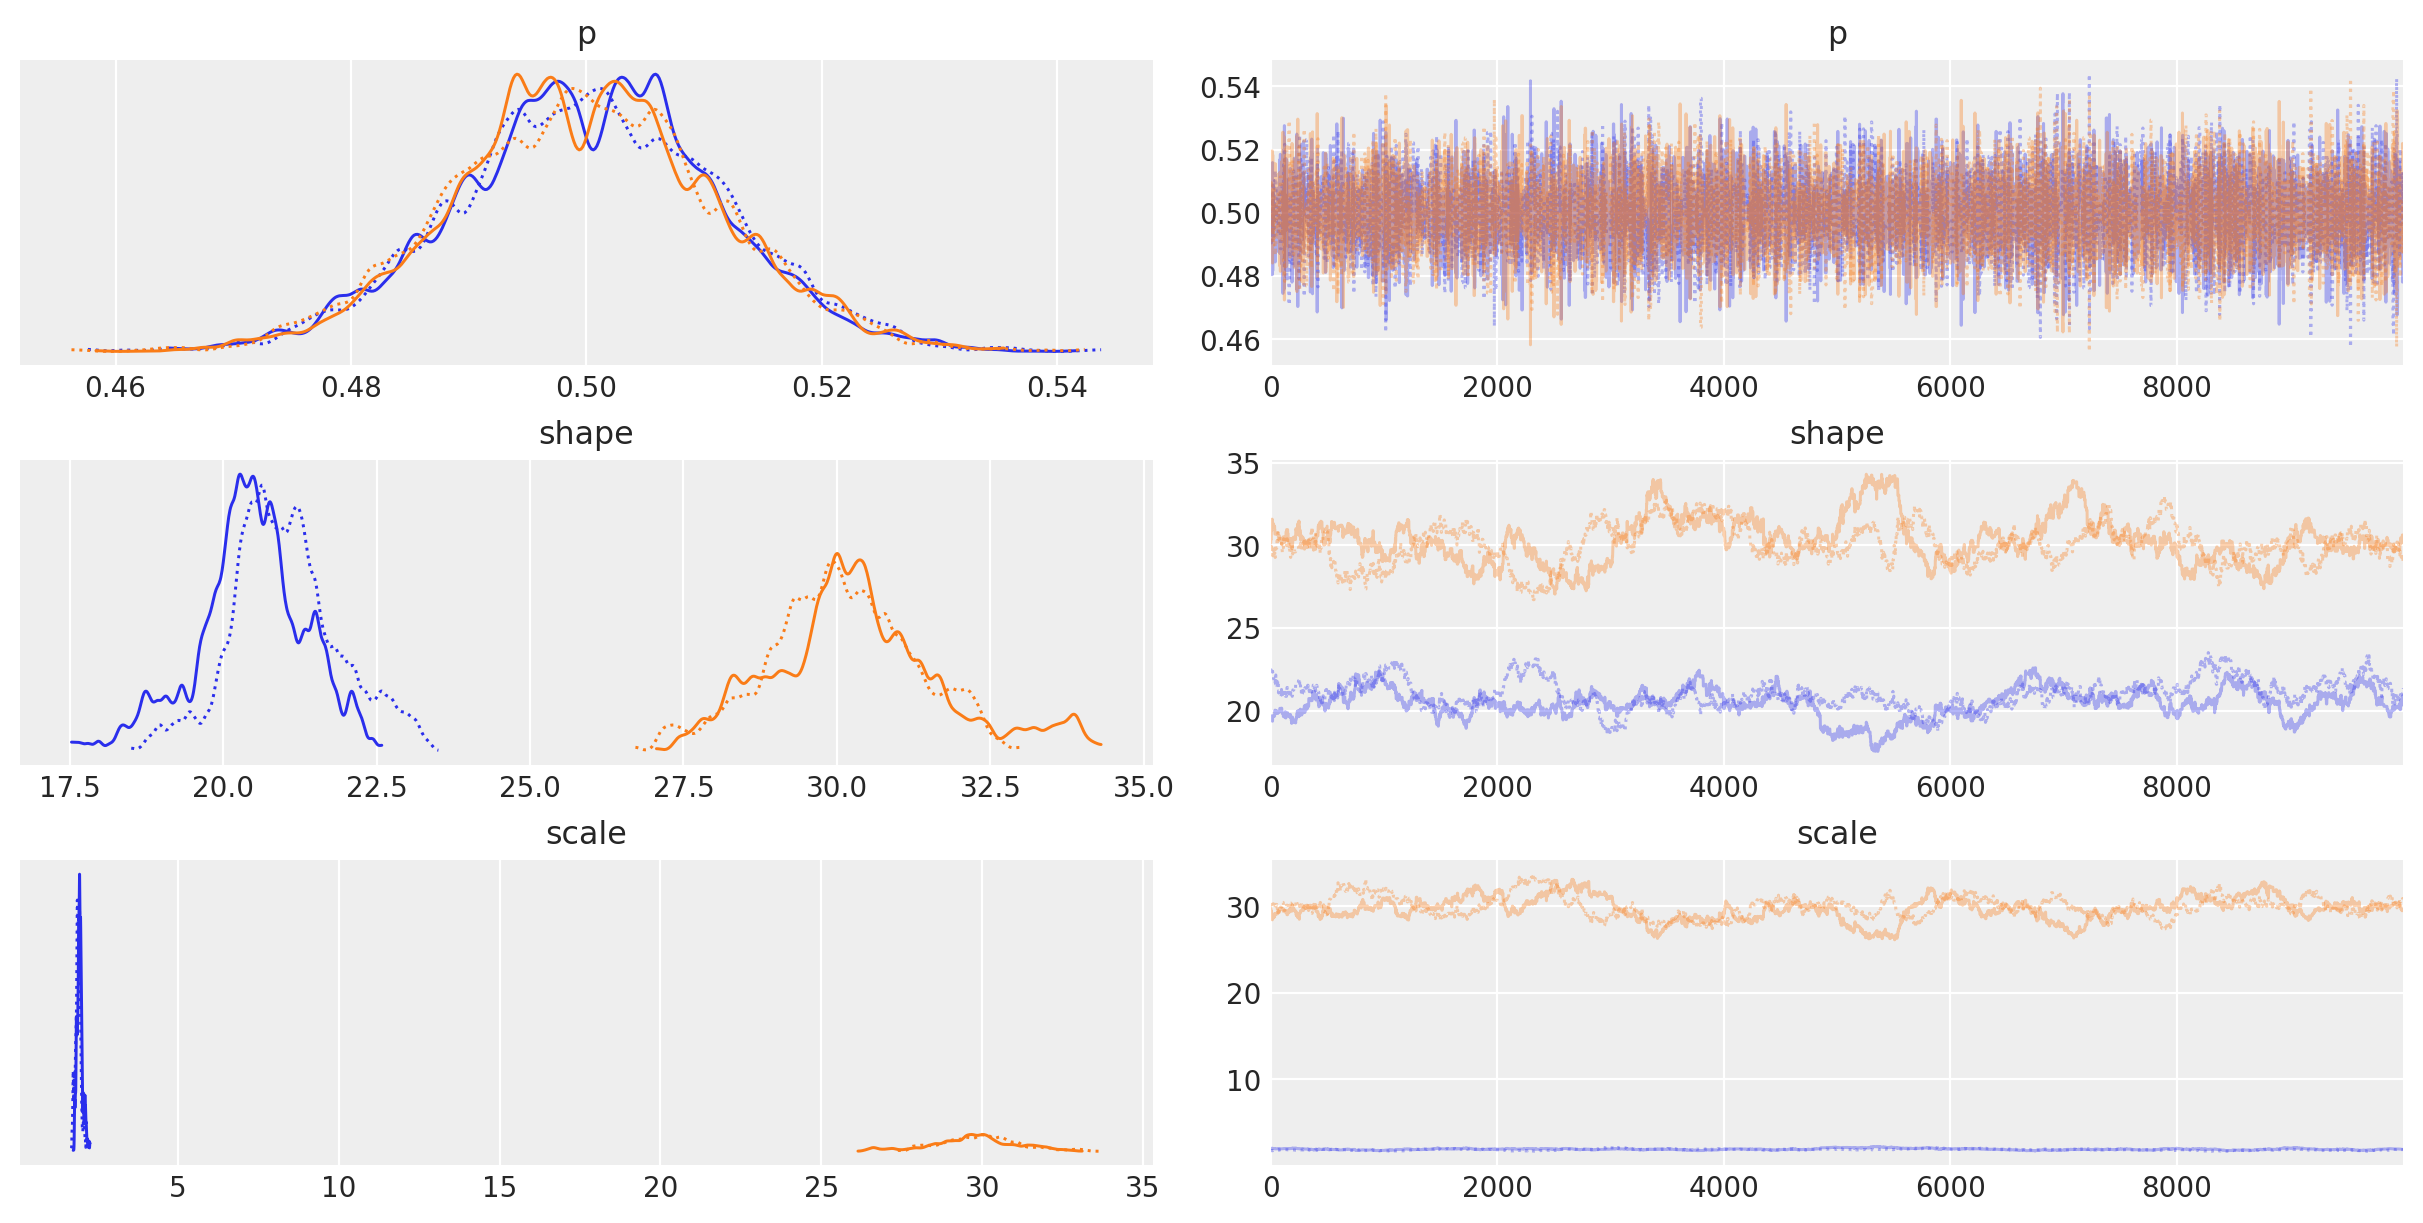

In [22]:
pm.traceplot(tr, var_names=["p", "shape", "scale"])

In [23]:
pm.summary(tr, var_names=["p", "shape", "scale"])

/usr/local/lib/python3.7/site-packages/arviz/data/io_pymc3.py:100: FutureWarning: Using `from_pymc3` without the model will be deprecated in a future release. Not using the model will return less accurate and less useful results. Make sure you use the model argument or call from_pymc3 within a model context.
  FutureWarning,


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
p[0],0.500,0.011,0.478,0.520,0.000,0.000,3868.0,3328.0,1.00
p[1],0.500,0.011,0.480,0.522,0.000,0.000,3868.0,3293.0,1.00
shape[0],20.730,0.921,18.740,22.453,0.188,0.135,24.0,34.0,1.07
shape[1],30.191,1.297,27.563,32.497,0.197,0.140,44.0,66.0,1.01
scale[0],1.923,0.087,1.737,2.092,0.018,0.013,24.0,36.0,1.07
scale[1],29.863,1.279,27.611,32.581,0.194,0.138,44.0,62.0,1.01
